In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial, comb
from tqdm import tqdm

from thewalrus.quantum import Amat, Qmat
from thewalrus._hafnian import hafnian

In [4]:
def get_probs(samples, cov, N, k): # N is the number of photon numbers and k is the length
    Q = Qmat(cov)
    amat = Amat(cov)
    sq_det_Q = np.sqrt(np.linalg.det(Q))

    sub_samples = samples[np.nonzero(np.sum(samples, axis = 1) == N)]

    prob = []
    for sample in tqdm(sub_samples[:k]):
        nums = np.tile(sample, 2)
        amat2 = np.repeat(np.repeat(amat, nums, axis = 0), nums, axis = 1)
        prob.append(hafnian(amat2) / np.product(factorial(sample)))

    return np.abs(prob / sq_det_Q)

In [ ]:
dir = "<replace/with/your/own/file/directory>"
cov = np.load(dir + "cov.npy")
sq_cov = np.load(dir + "sq_cov.npy")
thermal_cov = cov - sq_cov
M = len(cov) // 2

# To avoid negative eigenvalues due to numerical error
thermal_cov = thermal_cov + np.eye(len(thermal_cov)) * np.abs(np.min(np.linalg.eigvalsh(thermal_cov))) * 1.0001

probs_ideal = np.load("tot_probs.npy") # needs to be computed in advance

d = 4
chi = 10 ** 4 
samples_MPS = np.load("<replace_with_your_MPS_samples.npy>") 
samples_exp = np.load("<replace_with_experimental_samples.npy>") 

k = 10  # k is the number of samples to compute probabilities
probs_MPS = [] 
for N in range(10, 23): # range of photon sectors
    probs_MPS.append(get_probs(samples_MPS, cov, N, k)) 
    
probs_exp = [] 
for N in range(10, 23): # range of photon sectors
    probs_exp.append(get_probs(samples_exp, cov, N, k))     

scores = [] 
N_array = np.arange(10, 23) 
for N in N_array:
    prob_exp = probs_exp[N - 10] 
    score_exp = np.average(np.log(prob_exp / (probs_ideal[N] / comb(N + M - 1, N))))         
    
    prob_MPS = probs_MPS[N - 10] 
    score_MPS = np.average(np.log(prob_MPS / (probs_ideal[N] / comb(N + M - 1, N))))             
    
    scores.append([score_exp, score_MPS]) 
scores = np.array(scores)

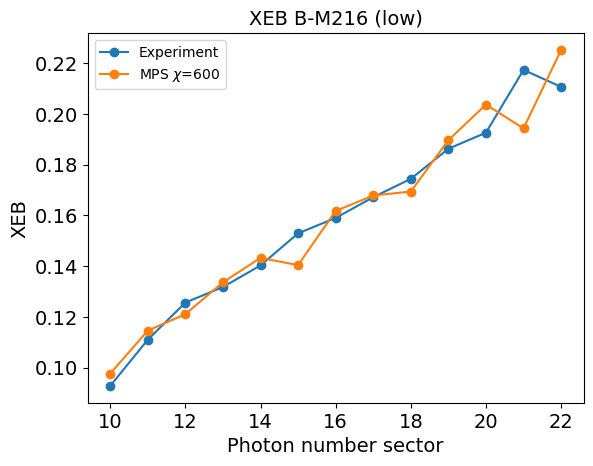

In [36]:
plt.plot(N_array, scores[:, 0], '-o', label = "Experiment")
plt.plot(N_array, scores[:, 1], '-o', label = "MPS $\chi$=600")
plt.xlabel("Photon number sector", fontsize = 14)
plt.ylabel("XEB", fontsize = 14)
plt.title("XEB B-M216 (low)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 10)